In [1]:
#from __future__ import print_function
#from __future__ import absolute_import
#from __future__ import division


import torch 
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dataset
import visdom
import sys,argparse,os

from models import scribbler, discriminator
import torch.optim as optim

from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import visualize
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import display
import torchvision.models as models
from dataloader import imfol

from utils.visualize import vis_patch, vis_image
        
from torch.utils.data import DataLoader
from dataloader.imfol import ImageFolder, make_dataset
from utils import transforms as custom_trans
import torchvision.transforms as tforms
import utils.transforms as utforms

from networks import define_G, weights_init
from models import scribbler 
import visdom

In [2]:
def clamp_image(img):
    img[:,0,:,:].clamp_(0,1)
    img[:,1,:,:].clamp_(-1.5,1.5)
    img[:,2,:,:].clamp_(-1.5,1.5)
    return img    

In [3]:
class toLAB(object):
    
    def __init__(self):
        self.space = 'LAB'
        
    def __call__(self, image ):
        lab_img = color.rgb2lab(np.array(img)/255.0)
        return lab_img
    
class toRGB(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, img):
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        rgb_img = color.lab2rgb(np.array(npimg))
        return rgb_img
    
class toTensor(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, pic):
        img = torch.from_numpy(pic.transpose((2, 0, 1)))
        return img

class randomCrop(object):
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, img):
        #random crop here
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        rgb_img = color.lab2rgb(np.array(npimg))
        return rgb_img

In [11]:
def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    
###############added options#######################################
    parser.add_argument('-learning_rate', default=1e-8, type=float,
                    help='Learning rate for the generator')
    parser.add_argument('-learning_rate_D',  default=1e-5,type=float,
                    help='Learning rate for the discriminator')    
    
    parser.add_argument('-gan', default='dcgan',type=str,choices=['dcgan', 'lsgan'],
                    help='dcgan|lsgan') #todo wgan/improved wgan    
    
    parser.add_argument('-model', default='pix2pix',type=str,choices=['scribbler', 'pix2pix'],
                   help='scribbler|pix2pix')
    
    parser.add_argument('-num_epoch',  default=1,type=int,
                    help='texture|scribbler')   
    
    parser.add_argument('-visualize_every',  default=10,type=int,
                    help='no. iteration to visualize the results')      

    #all the weights ratio, might wanna make them sum to one
    parser.add_argument('-feature_weight', default=1,type=float,
                       help='weight ratio for feature loss')
    parser.add_argument('-pixel_weight_l', default=100,type=float,
                       help='weight ratio for pixel loss for l channel')
    parser.add_argument('-pixel_weight_ab', default=100,type=float,
                   help='weight ratio for pixel loss for ab channel')
   
    parser.add_argument('-discriminator_weight', default=1,type=float,
                   help='weight ratio for the discriminator loss')
    parser.add_argument('-style_weight', default = 1, type=float, 
                        help='weight ratio for the texture loss')


    parser.add_argument('-gpu', default=1,type=int,
                   help='id of gpu to use') #TODO support cpu

    parser.add_argument('-display_port', default=8889,type=int,
               help='port for displaying on visdom (need to match with visdom currently open port)')

    parser.add_argument('-data_path', default='/home/psangkloy3/training_handbags_pretrain/',type=str,
                   help='path to the data directory, expect train_skg, train_img, val_skg, val_img')

    parser.add_argument('-save_dir', default='/home/psangkloy3/texturegan/save_dir',type=str,
                   help='path to save the model')
    parser.add_argument('-save_every',  default=1000,type=int,
                    help='no. iteration to save the models')
    
    parser.add_argument('-load', default=1000,type=int,
                   help='load generator and discrminator from iteration n')
    parser.add_argument('-load_D', default=1000,type=float,
                   help='load discriminator from iteration n, priority over load')
    
    parser.add_argument('-image_size',default=224,type=int,
                    help='Training images size, after cropping')        
    parser.add_argument('-resize_max',  default=1,type=int,
                    help='max resize, ratio of the original image, max value is 1')        
    parser.add_argument('-resize_min',  default=0.6,type=int,
                    help='min resize, ratio of the original image, min value 0')   
    
############################################################################
############################################################################
############TODO: TO ADD#################################################################
    parser.add_argument('-tv_weight', default=1,type=float,
                   help='weight ratio for total variation loss')
    parser.add_argument('-content_layers',  default='relu2_2',type=str,
                    help='Layer to attach content loss.')
    
    parser.add_argument('-batch_size', default=1) #fixed batch size 1
    
    

    
    parser.add_argument('-mode',  default='texture',type=str,choices=['texture','scribbler'],
                    help='texture|scribbler') 
    
   
    parser.add_argument('-crop',  default='random',type=str,choices=['random','center'],
                    help='random|center')
    
    parser.add_argument('-contrast',  default=True,type=bool,
                    help='randomly adjusting contrast on sketch')
    
    parser.add_argument('-occlude', default=False,type=bool,
                       help='randomly occlude part of the sketch')
    
    
    parser.add_argument('-checkpoints_path', default='data/',type=str,
                   help='output directory for results and models')
    

    
    parser.add_argument('-noise_gen', default=False,type=bool,
                   help='whether or not to inject noise into the network')
    
    
    parser.add_argument('-absolute_load', default='',type=str,
                   help='load saved generator model from absolute location')
    
    
    
    
##################################################################################################################################    
    
    return parser.parse_args(argv)

In [12]:
command = '-content_layers relu2_2 -feature_weight 100 -pixel_weight_ab 1 -tv_weight 0.0001 -model scribbler_custom -data_path /home/psangkloy3/training_handbag_pretrain/ -gpu 1 -display_port 7779 -image_size 128 -save_every 5000 -visualize_every 10 -discriminator_weight 0 -learning_rate 1e-3 -learning_rate_D 1e-6 -batch_size 6 -contrast True -resize_max 256 -resize_min 128 -gan lsgan -load 100000'
command = ''
args = parse_arguments(command.split())

In [13]:

with torch.cuda.device(args.gpu):
    
    vis=visdom.Visdom(port=args.display_port)
    
    Loss_g_graph=[]
    Loss_gd_graph=[]
    Loss_gf_graph = []
    Loss_gp_graph = []
    Loss_gs_graph = []
    Loss_d_graph=[]

    ts=custom_trans.Compose([custom_trans.RandomSizedCrop(args.image_size,args.resize_min,args.resize_max),custom_trans.RandomHorizontalFlip() ,custom_trans.toLAB(), custom_trans.toTensor()])
    rgbify = custom_trans.toRGB()
    dset = ImageFolder(args.data_path,ts)
    dataloader=DataLoader(dataset=dset, batch_size=1, shuffle=True)
    
    sigmoid_flag = 1
    if args.gan =='lsgan':
        sigmoid_flag = 0 
        
    if args.model=='scribbler':
        netG=scribbler.Scribbler(3,3,32)
    elif args.model=='pix2pix':
        netG=define_G(3,3,32)
    else:
        print(args.model+ ' not support. Using pix2pix model')
        netG=define_G(3,3,32)
    netD=discriminator.Discriminator(3,32,sigmoid_flag)  
    feat_model=models.vgg19(pretrained=True)
    if args.load == -1:
        netG.apply(weights_init)
    else:
        
        load_network(netG,'G',args.load,args.save_dir)
        print('Loaded G from itr:' + str(args.load))
    if args.load_D == -1:
        netD.apply(weights_init)  
    else:
        load_network(netD,'D',args.load_D,args.save_dir)
        print('Loaded D from itr:' + str(args.load_D))
    
    if args.gan =='lsgan':
        criterion_gan = nn.MSELoss()
    elif args.gan =='dcgan':
        criterion_gan = nn.BCELoss()
        
    criterion_l1 = nn.L1Loss()
    criterion_style = nn.L1Loss()
    criterion_feat = nn.L1Loss()

    input_skg = torch.FloatTensor(2, 3, 256, 256)
    output_img = torch.FloatTensor(2, 3, 256, 256)
    segment = torch.FloatTensor(2, 3, 256, 256)
    label = torch.FloatTensor(2)
    real_label = 1
    fake_label = 0

    optimizerD = optim.Adam(netD.parameters(), lr=args.learning_rate_D, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=args.learning_rate, betas=(0.5, 0.999))

    netG.cuda()
    netD.cuda()
    feat_model.cuda()
    criterion_gan.cuda()
    criterion_l1.cuda()
    criterion_feat.cuda()
    input_skg, output_img, segment, label = input_skg.cuda(), output_img.cuda(),segment.cuda(), label.cuda()


    for epoch in range(args.num_epoch):
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            img, skg,seg = data
            img=utforms.normalize_lab(img)
            skg=utforms.normalize_lab(skg)
            
            img=img.cuda()
            skg=skg.cuda()
            seg=seg.cuda()
            
            input_skg.resize_as_(skg.float()).copy_(skg)
            output_img.resize_as_(img.float()).copy_(img)
            segment.resize_as_(seg.float()).copy_(seg)
            
            inputv = Variable(input_skg)
            outputv = Variable(output_img)
            labelv = Variable(label)
            #print labelv.data.size()

            output = netD(inputv)
            
            label.resize_(output.data.size())
            labelv = Variable(label.fill_(real_label))
            errD_real = criterion_gan(output, labelv)
            errD_real.backward()
            D_x = output.data.mean()

            # train with fake
            #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
            #noisev = Variable(noise)
            fake = netG(inputv)
            #TODO only fed L channel to D
            L,A,B=torch.chunk(fake,3,dim=1)
            ##################################
            #TODO add threshold to stop updating D
            output = netD(fake.detach())
            label.resize_(output.data.size())
            labelv = Variable(label.fill_(fake_label))

            errD_fake = criterion_gan(output, labelv)
            errD_fake.backward()
            D_G_z1 = output.data.mean()
            errD = errD_real + errD_fake
            Loss_d_graph.append(errD.data[0])
            optimizerD.step()
            #TODO add discriminator accuracy

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
            #TODO only fed L channel to D
            output = netD(fake)
            
            multer=torch.ones(inputv.data.size())
            multer[:,1:,:,:]=args.pixel_weight_ab*multer[:,1:,:,:]
            multer=multer.cuda()
            multer=Variable(multer)
            
            multer_=torch.ones(inputv.data.size())
            multer_[:,0,:,:]=args.pixel_weight_l*multer_[:,0,:,:]
            multer_=multer_.cuda()
            multer_=Variable(multer_)
            
            #print outputv.size(), multer.size()
            woutputv = outputv*multer*multer_
            
            err_pixel = criterion_l1(fake*multer*multer_, woutputv)
            #print(err_pixel.data[0])
            #break
            #####################################
            D_G_z2 = output.data.mean()
            
            label.resize_(output.data.size())
            labelv = Variable(label.fill_(real_label))

            err_gan = args.discriminator_weight*criterion_gan(output, labelv)
            
            ####################################
            #TODO normalize and minus mean?
            #L,A,B=torch.chunk(fake,3,dim=1)
            LLL=torch.cat((L,L,L),1)
            Extract = FeatureExtractor(feat_model.features, ['10'])
            out_feat = Extract(LLL)[0]
            
            #out_feat=feat_model.features(LLL)
            
            #print(LLL.size())
            #break
            gt_feat = Extract(outputv)[0]
            
            gt_feat = gt_feat.detach() #don't require grad for this
            
            err_feat = args.feature_weight*criterion_feat(out_feat,gt_feat)
            #err_feat.backward()
            
            # style loss
            Extract = FeatureExtractor(feat_model.features, ['0','5','10','19','28'])
            output_feature = Extract(LLL)
            target_feature = Extract(outputv)
            
            gram = GramMatrix()
            
            err_style = 0
            gram_style = [gram(y) for y in target_feature]
            for m in range(len(output_feature)):
                gram_y = gram(output_feature[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False)
                err_style += args.style_weight * criterion_style(gram_y, gram_s)
                #style_loss = StyleLoss(gram_s, style_weight)
                        
            err_G = err_pixel + err_gan + err_feat + err_style
            err_G.backward()
            
            optimizerG.step()
            Loss_g_graph.append(err_G.data[0])
            Loss_gp_graph.append(err_pixel.data[0])
            Loss_gd_graph.append(err_gan.data[0])
            Loss_gf_graph.append(err_feat.data[0])
            Loss_gs_graph.append(err_style.data[0])
            #plt.imshow(vis_image(inputv.data.double().cpu()))

            print i, err_G.data[0]
            
            if(i%args.save_every==0):
                save_network(netG,'G',i,args.gpu,args.save_dir)
                save_network(netD,'D',i,args.gpu,args.save_dir)
                
                
            #TODO test on test set
            if(i%args.visualize_every==0):
                test_img=clamp_image(fake.data.double().cpu())
                test_img=utforms.denormalize_lab(test_img)
                test_img=vis_image(test_img)
                test_img=(test_img*255).astype('uint8')
                test_img=np.transpose(test_img,(2,0,1))

                inp_img=vis_patch(utforms.denormalize_lab(img.cpu()),utforms.denormalize_lab(skg.cpu()))
                inp_img=(inp_img*255).astype('uint8')
                inp_img=np.transpose(inp_img,(2,0,1))
                
                target_img=vis_image(utforms.denormalize_lab(img.cpu()))
                target_img=(target_img*255).astype('uint8')
                target_img=np.transpose(target_img,(2,0,1))
                
                segment_img=vis_image((seg.cpu()))
                segment_img=(segment_img*255).astype('uint8')
                segment_img=np.transpose(segment_img,(2,0,1))
                
                vis.image(test_img,win='output',opts=dict(title='output'))
                vis.image(inp_img,win='input',opts=dict(title='input'))  
                vis.image(target_img,win='target',opts=dict(title='target'))
                vis.image(segment_img,win='segment',opts=dict(title='segment'))
                vis.line(np.array(Loss_gs_graph),win='gs',opts=dict(title='G-Style Loss'))
                vis.line(np.array(Loss_g_graph),win='g',opts=dict(title='G Total Loss'))
                vis.line(np.array(Loss_gd_graph),win='gd',opts=dict(title='G-Discriminator Loss'))
                vis.line(np.array(Loss_gf_graph),win='gf',opts=dict(title='G-Feature Loss'))
                vis.line(np.array(Loss_gp_graph),win='gp',opts=dict(title='G-Pixel Loss'))
                vis.line(np.array(Loss_d_graph),win='d',opts=dict(title='D Loss'))

Loaded G from itr:1000
Loaded D from itr:1000
0 28.9826221466
1 34.8050003052
2 31.4345836639
3 31.436214447
4 29.560880661
5 45.160446167
6 29.8853702545
7 23.3608589172
8 30.2891311646
9 26.8272953033
10 31.2786598206
11 26.9011554718
12 30.8486614227
13 30.7911319733
14 32.7120780945
15 35.5620613098
16 26.5152359009
17 28.65675354
18 24.9338493347
19 34.7211265564
20 33.0106163025


/root/anaconda2/lib/python2.7/site-packages/skimage/color/colorconv.py:901: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


21 34.5780220032
22 29.8062858582
23 38.2177696228
24 28.5278358459
25 28.1471214294
26 35.4347419739
27 18.5281181335
28 36.501701355
29 24.7285633087
30 20.9316139221
31 19.6083221436
32 28.746213913
33 32.879940033
34 28.4379463196
35 36.1495361328
36 23.7602214813
37 24.0270786285
38 27.8342266083
39 39.5543861389
40 45.9514389038
41 33.2403869629
42 36.875957489
43 34.3026428223
44 38.4192733765
45 36.3499031067
46 42.2621574402
47 19.3559894562
48 40.6955604553
49 38.2883529663
50 23.9452552795
51 42.3568382263
52 21.003484726
53 24.6862201691
54 38.855430603
55 31.6465091705
56 31.6302204132
57 33.4685935974
58 32.016784668
59 30.0155124664
60 28.6324176788
61 32.7201309204
62 32.6877670288
63 44.8796768188
64 38.1060943604
65 25.5008583069
66 26.9304409027
67 27.2527770996
68 32.8143959045
69 29.5295639038
70 27.9342193604
71 21.9980792999
72 27.2832794189
73 47.1186828613
74 38.2130622864
75 23.3994369507
76 42.4752006531
77 40.9607009888
78 51.040977478
79 40.330997467
80 30.

/root/anaconda2/lib/python2.7/site-packages/skimage/color/colorconv.py:901: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


561 22.1165561676
562 46.6272735596
563 31.7858448029
564 34.2438812256
565 37.2527618408
566 25.6859607697
567 39.1658058167
568 23.9594631195
569 37.7777366638
570 41.7541885376
571 37.1991271973
572 34.255657196
573 26.4350128174
574 25.7110519409
575 37.2404975891


KeyboardInterrupt: 

In [26]:
dataloader

In [17]:
test = []
test.append('')

In [6]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # normalize the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [7]:
class FeatureExtractor(nn.Module):
    # Extract features from intermediate layers of a network

    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor,self).__init__()
        self.submodule = submodule
        self.extracted_layers=extracted_layers

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            x = module(x)
            if name in self.extracted_layers:
                outputs += [x]
        return outputs + [x]

In [18]:
fake

Variable containing:
( 0 , 0 ,.,.) = 
  1.7196e-01 -6.1589e-02 -2.1210e-02  ...  -5.1205e-02  4.5337e-01  2.0546e-01
  2.6643e-01  2.5032e-01  4.8722e-01  ...   3.6831e-01  3.8454e-01  3.3580e-01
  2.5382e-01  4.4202e-01 -1.8710e-03  ...   3.7565e-01  2.0861e-01  8.1030e-02
                 ...                   ⋱                   ...                
 -1.7572e-01 -3.2046e-02  2.7267e-01  ...   3.6335e-03  5.3113e-02  1.8549e-01
 -2.4585e-01 -7.0749e-03 -9.0002e-02  ...   2.4865e-02  5.9739e-02 -8.8758e-02
 -2.6773e-01 -1.5840e-01  4.0324e-02  ...  -5.1261e-03  1.2736e-02 -3.2019e-02

( 0 , 1 ,.,.) = 
 -3.1054e-02  2.3535e-01 -6.3901e-02  ...  -1.4524e-01 -5.2231e-02  7.5826e-03
 -4.2265e-02  1.7463e-01 -5.2869e-02  ...  -7.4345e-02  1.7718e-01  1.4307e-01
  2.9120e-01  2.4051e-01  4.3200e-02  ...   7.3742e-02  1.2593e-01 -5.4315e-02
                 ...                   ⋱                   ...                
 -1.3579e-01 -1.7391e-01 -3.5976e-01  ...  -3.4981e-01 -3.2792e-01 -9.6030e

In [8]:
def save_network(model, network_label, epoch_label, gpu_id, save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_filename)
    torch.save(model.cpu().state_dict(), save_path)
    model.cuda(device_id=gpu_id)

In [9]:
def load_network(model, network_label, epoch_label,save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(save_dir, save_filename)
    model.load_state_dict(torch.load(save_path))

In [35]:
#TODO normalize and minus mean
feat_model=models.vgg19(pretrained=True)
lab_var = fake
L,A,B=torch.chunk(lab_var,3,dim=1)
LLL=torch.cat((L,L,L),1)
out=feat_model.features(LLL)

RuntimeError: tensors are on different GPUs

In [81]:
import torchvision.transforms
from __future__ import division
import torch
import math
import random
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections

In [124]:

class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, imgs):
        for t in self.transforms:
            imgs = t(imgs)
        return imgs

class Scale(object):
    """Rescale multiple input PIL.Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (w, h), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
        self.transform = torchvision.transforms.Scale(size)

    def __call__(self, imgs):
        """
        Args:
            imgs (list of PIL.Image): Images to be scaled.
        Returns:
            list of PIL.Image: Rescaled images.
        """
        results = []
        #w,h = imgs[0].size
        for img in imgs:
            if isinstance(self.size, int):
                #ww, hh = img.size
                
                #img,skg,seg have to all have the same size
                #assert w==ww, 'inconsistent image size'
                #assert h==hh, 'inconsistent image size'
                
                results.append(self.transform(img))
                
        return [self.transform(img) for img in imgs]

class CenterCrop(object):
    """Crops the given PIL.Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.transform = torchvision.transforms.CenterCrop(size)

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        return [self.transform(img) for img in imgs]
    
class Pad(object):
    """Pad the given PIL.Image on all sides with the given "pad" value.
    Args:
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill: Pixel fill value. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
    """

    def __init__(self, padding, fill=0):
        assert isinstance(padding, (numbers.Number, tuple))
        assert isinstance(fill, (numbers.Number, str, tuple))
        if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
            raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                             "{} element tuple".format(len(padding)))

        self.padding = padding
        self.fill = fill
        
        self.transform = torchvision.transforms.Pad(padding,fill)

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be padded.
        Returns:
            PIL.Image: Padded image.
        """
        
        return [self.transform(img) for img in imgs]

class RandomCrop(object):
    """Crop the given PIL.Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        if self.padding > 0:
            imgs = [ImageOps.expand(img, border=self.padding, fill=0) for img in imgs]

        w, h = imgs[0].size
        th, tw = self.size
        if w == tw and h == th:
            return imgs

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return [img.crop((x1, y1, x1 + tw, y1 + th)) for img in imgs]

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL.Image randomly with a probability of 0.5."""

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return [img.transpose(Image.FLIP_LEFT_RIGHT) for img in imgs]
        return imgs

class RandomSizedCrop(object):
    """Crop the given PIL.Image to random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: size of the smaller edge
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, min_resize=0.08,max_resize=1.0,interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.resize_size = (min_resize,max_resize)

    def __call__(self, imgs):
        for attempt in range(10):
            area = imgs[0].size[0] * imgs[0].size[1]
            target_area = random.uniform(self.resize_size[0], self.resize_size[1]) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= imgs[0].size[0] and h <= imgs[0].size[1]:
                x1 = random.randint(0, imgs[0].size[0] - w)
                y1 = random.randint(0, imgs[0].size[1] - h)

                imgs = [img.crop((x1, y1, x1 + w, y1 + h)) for img in imgs]
                assert([img.size == (w, h) for img in imgs])

                return [img.resize((self.size, self.size), self.interpolation) for img in imgs]

        # Fallback
        scale = Scale(self.size, interpolation=self.interpolation)
        crop = CenterCrop(self.size)
        return crop(scale(imgs))

    

In [125]:
tf = Compose([RandomSizedCrop(224,0.5,1),RandomHorizontalFlip()])
output = tf(images)

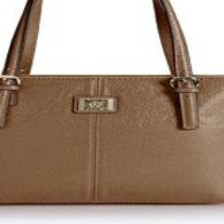

In [127]:
output[0]

In [33]:
images = []
img_dir = '/home/psangkloy3/training_handbags_pretrain/'
suffix = 'wendy/100_AB.jpg'
paths = [img_dir+p+suffix for p in ['val_img/','val_skg/','val_seg/']]
for path in paths:
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            images.append(img.convert('RGB'))
            

In [43]:
import glob
def make_dataset(dir):
    train_img=glob.glob(dir+'val_img/wendy/*.jpg')
    train_img=sorted(train_img)
    train_skg=glob.glob(dir+'val_skg/wendy/*.jpg')
    train_skg=sorted(train_skg)
    train_seg=glob.glob(dir+'val_seg/wendy/*.jpg')
    train_seg=sorted(train_seg)
    
    return zip(train_img,train_skg,train_seg)


In [44]:
test = make_dataset(img_dir)

In [47]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

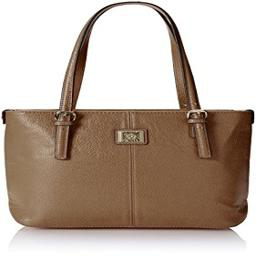

In [56]:
images[0]

(256, 256)